### 전력 수요량 예측 경진대회 코드리뷰 - 3위
- https://dacon.io/competitions/official/196878/codeshare/416?page=1&dtype=recent&ptype=pub

### 배경
- 전력수요예측 시뮬레이션을 통한 효율적인 빅데이터 분석기법 발굴
- 전력 융합신서비스 발굴 및 비즈니스 모델 개발 활용
- 창의적인 아이디어와 빅데이터 분석기술을 토대로 에너지 신서비스 개발 촉진

### 문제
- 본 대회에서는, 기존 전력 사용 기록과 기상 데이터 등 공공 데이터를 이용하여, 각 가정 및 회사의 시간별, 일별, 월별 전력 사용량을 예측합니다. **2018년 7월1일부터 2018년 - 11월 30일까지의 에너지 사용량을 예측**합니다. 보다 정확히는 다음을 예측합니다.
- 2018년 **7월 1일 00시부터 24시까지**, 24시간, ‘시간당 전력사용량’ (24개) 
- 2018년 **7월 1일부터 7월10일까지, 10일간**, ‘일간 전력사용량’ (10개)
- 2018년 **7월 부터 11월까지, 5개월간**, ‘월간 전력사용량’ (5개)
- 즉 각 세대(또는 상가)당 39개(24개,10개,5개)의 값을 예측해야 합니다.

### 데이터
- 본 대회에서는 2016년 7월 20일부터 2018년 6월 30일까지의 국내 특정 지역의 아파트들과 상가의 전력에너지 사용량이 주어집니다. 자세한 사항은 첨부파일로 포함합니다.
- * 주의: 제공되는 데이터에는 결측치나 이상치(NA, 0인 값)가 포함되어 있습니다. 대회참가자들은 이러한 결측치를 고려하여, 결측치 처리 등 예측 기법을 적용하여야 합니다.
- 참고로, NA가 발생한 경우, 직전 시간의 전력사용량 값이 상당히 큰 경향이 있습니다. 이는 미터링 데이터 수집 시스템의 특징으로 보입니다. 그러나 반드시 그런 것은 아닙니다.

#### ① train.csv
- 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (1300호)
- 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량

#### ② test.csv
- 국내(인천지역) 특정 지역의 모 아파트 및 모 상가의 전력사용량. (200호)
- 2017년 7월 1일 00시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량
* train의 세대와 다른 세대

#### ③ submission.csv
- test셋에 제시된 세대(상가)에 대한 예측값들을 제출하는 포맷
- 본 대회에서는 2016년 7월 20일부터 2018년 6월 30일까지의 국내 특정 지역의 아파트들과 상가의 전력에너지 사용량이 주어집니다. 자세한 사항은 첨부파일로 포함

### 1. 라이브러리 및 데이터
### Library & Data

In [1]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import os # 경로 설정
import tqdm # 진행상황 파악 - 진행바
import datetime # 날짜타입 사용
import random # 시드 제어
from collections import defaultdict # dict 자료구조

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold # 일반화

import lightgbm as lgb

# 공휴일 체크 하는 함수 is_holiday()
from workalendar.asia import SouthKorea # 한국의 공휴일, version : 1.1.1 

#사용한 데이터 불러오기
test = pd.read_csv("data/test.csv") # 대회 데이터
sub = pd.read_csv("data/submission.csv") # 대회 데이터
train = pd.read_csv("data/train.csv", engine='python') # train data # 거의다 NA 값?
weather = pd.read_csv("data/인천_시간별__기상자료(16-18)_축소__7월1일.csv", encoding='cp949') # 대회 데이터
# weather = pd.read_csv("data/weather_hour.csv", encoding='cp949') # 대회 데이터
print('데이터 로드 완료')

데이터 로드 완료


In [13]:
# 1300가구의 전기사용량 데이터 - 2016-07-26-11:00 ~ 2018-06-30-23:00
print(train.shape)
train 

(16909, 1301)


,Time,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,...,NX1291,NX1292,NX1293,NX1294,NX1295,NX1296,NX1297,NX1298,NX1299,NX1300
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00,0.271,0.754,0.327,0.468,NaN,0.314,0.769,0.790,0.558,...,0.523,0.455,0.295,0.056,0.295,2.089,0.619,1.063,0.345,0.565
16905,2018-06-30 20:00,0.341,0.827,0.478,0.356,NaN,0.434,0.680,0.819,0.470,...,0.350,0.799,0.287,0.057,0.548,2.168,0.723,4.760,0.388,0.620
16906,2018-06-30 21:00,0.535,0.516,0.558,0.496,NaN,0.479,0.590,0.910,0.424,...,0.446,0.754,0.433,0.060,0.677,2.028,0.766,5.386,0.440,0.573
16907,2018-06-30 22:00,0.379,0.494,0.605,0.320,NaN,0.555,0.604,1.044,0.412,...,0.567,0.504,0.384,0.210,1.019,1.055,0.735,7.150,0.393,0.629


In [4]:
#train['Time'].sort_index().unique()

In [11]:
# test data 200가구 - 2017-7-1-00시 ~ 2018-06-30-23시
print(test.shape)
test

(8760, 201)


,Time,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,...,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500
0,2017.7.1 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
1,2017.7.1 1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2,2017.7.1 2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
3,2017.7.1 3:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
4,2017.7.1 4:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018.6.30 19:00,1.255,0.175,0.430,0.429,0.169,0.739,0.573,0.341,0.127,...,0.312,0.381,0.479,0.858,11.546,0.428,0.134,3.519,0.027,0.286
8756,2018.6.30 20:00,1.596,1.692,0.332,0.366,0.159,0.255,0.501,0.281,0.126,...,0.327,0.402,0.725,0.816,11.591,0.413,0.206,3.331,0.027,0.303
8757,2018.6.30 21:00,1.379,0.883,0.435,0.497,0.166,0.233,0.634,0.401,0.439,...,0.253,0.401,0.426,0.659,10.766,0.466,0.324,3.416,0.026,0.253
8758,2018.6.30 22:00,1.000,0.539,0.268,0.459,0.463,0.454,0.676,0.543,0.737,...,0.332,0.401,0.353,0.462,0.312,0.473,0.402,4.263,0.027,0.253


In [5]:
# 인천시 16년 7월 20일 00시 부터 ~ 18년 7월 1일 23시까지 의 기온 데이터 
print(weather.shape)
weather

## 일시, 기온만 사용

(17088, 9)


,지점,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),날씨,전운량(10분위)
0,112,2016.7.20 0:00,25.7,NaN,1.3,98.0,NaN,박무,8.0
1,112,2016.7.20 1:00,25.6,NaN,1.4,98.0,NaN,NaN,NaN
2,112,2016.7.20 2:00,25.4,NaN,0.3,98.0,NaN,NaN,NaN
3,112,2016.7.20 3:00,24.9,NaN,1.1,98.0,NaN,박무,8.0
4,112,2016.7.20 4:00,24.7,NaN,0.7,98.0,NaN,박무,8.0
...,...,...,...,...,...,...,...,...,...
17083,112,2018.7.1 19:00,21.6,1.8,5.1,98.0,NaN,약한비계속,10.0
17084,112,2018.7.1 20:00,21.4,1.3,5.0,98.0,NaN,약한비계속,10.0
17085,112,2018.7.1 21:00,21.3,4.2,4.5,98.0,NaN,보통비계속,10.0
17086,112,2018.7.1 22:00,21.3,6.2,4.8,98.0,NaN,보통비계속,10.0


### 제출파일 형태
- 'meter_id' 

### 7월 1일 24시간
- 'X2018_7_1_1h', 'X2018_7_1_2h', 'X2018_7_1_3h', 'X2018_7_1_4h', 'X2018_7_1_5h', 'X2018_7_1_6h', 'X2018_7_1_7h', 'X2018_7_1_8h', 
- 'X2018_7_1_9h', 'X2018_7_1_10h', 'X2018_7_1_11h','X2018_7_1_12h', 'X2018_7_1_13h', 'X2018_7_1_14h', 'X2018_7_1_15h', 'X2018_7_1_16h',
- 'X2018_7_1_17h','X2018_7_1_18h','X2018_7_1_19h','X2018_7_1_20h', 'X2018_7_1_21h', 'X2018_7_1_22h', 'X2018_7_1_23h', 'X2018_7_1_24h', 

### 7월 1일 ~ 7월 10일 일별 사용량 (10일)
- 'X2018_7_1_d', 'X2018_7_2_d', 'X2018_7_3_d', 'X2018_7_4_d', 'X2018_7_5_d', 
- 'X2018_7_6_d', 'X2018_7_7_d', 'X2018_7_8_d', 'X2018_7_9_d', 'X2018_7_10_d'

### 7월 ~ 11월 월별 사용량 (5개월)
- 'X2018_7_m', 'X2018_8_m', 'X2018_9_m', 'X2018_10_m', 'X2018_11_m'

In [6]:
# TEST DATA와 같은 아파트
print(sub.shape)
sub

(200, 40)


,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,NX1301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NX1302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NX1303,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NX1304,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NX1305,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NX1496,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,NX1497,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,NX1498,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,NX1499,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. 데이터 전처리
### Data Cleansing & Pre-Processing

In [7]:
# 시드를 고정하는 함수
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

# weather 데이터 는 일시와 기온만 사용
weather['일시'] = pd.to_datetime(weather['일시'])
weather = weather.iloc[:, 1:3]
weather.columns = ['Time', 'temp'] # temperature
weather.head()

,Time,temp
0,2016-07-20 00:00:00,25.7
1,2016-07-20 01:00:00,25.6
2,2016-07-20 02:00:00,25.4
3,2016-07-20 03:00:00,24.9
4,2016-07-20 04:00:00,24.7


In [8]:
# 16, 17, 18년 공휴일 SouthKorea - 공휴일 체크
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]), 
                      pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]), 
                      pd.Series(np.array(SouthKorea().holidays(2016))[:, 0])]).reset_index(drop=True)
holidays

0     2018-01-01
1     2018-02-15
2     2018-02-16
3     2018-02-17
4     2018-03-01
5     2018-05-05
6     2018-05-22
7     2018-06-06
8     2018-08-15
9     2018-09-23
10    2018-09-24
11    2018-09-25
12    2018-10-03
13    2018-10-09
14    2018-12-25
15    2017-01-01
16    2017-01-27
17    2017-01-28
18    2017-01-29
19    2017-03-01
20    2017-05-03
21    2017-05-05
22    2017-06-06
23    2017-08-15
24    2017-10-03
25    2017-10-03
26    2017-10-04
27    2017-10-05
28    2017-10-09
29    2017-12-25
30    2016-01-01
31    2016-02-07
32    2016-02-08
33    2016-02-09
34    2016-03-01
35    2016-05-05
36    2016-05-14
37    2016-06-06
38    2016-08-15
39    2016-09-14
40    2016-09-15
41    2016-09-16
42    2016-10-03
43    2016-10-09
44    2016-12-25
dtype: object

#### 변수
- Time으로부터 생성하는 변수 : month, week, weekday, day, hour
- weekend와 holiday를 이용하여, 휴일을 정의
- **직전주차에 사용한 전력량의 std와 mean을 변수로 사용(only hour predict) -> 모델에 추세에 대한 정보를 부여하는 목적!! **
- **target 변수의 outlier를 제거하기 위해 평균을 기준으로 3sigma 외의 값들 clipping -> 이상값 인식 방법 중 하나** (ESD) 
- ESD (Extreme Studentized Deviation) : 평균으로부터 3표준편차 떨어진 값 

#### Case
- include temperature and hour predict (온도 및 시간 포함 예측 )
- exclude temperature and hour predict (온도 및 시간 제외 예측 )
- exclude temperature and day, month predict (온도 및 일 제외, 월 예측 )

In [171]:
#temp5 = train[train['Time']>='2018-04-18'].reset_index(drop=True) # 인덱스 열 버림     
#print(temp5.shape) # 5280이 나와야 됨.
#temp5 = temp5.loc[temp5.index[temp5['Time'].astype(str)!='nan'][0]:].reset_index(drop=True) # 
#temp5
#temp5.loc[temp5.index[temp5['Time'].astype(str)!='nan'][0]:]

In [14]:
#### Case
# - include temperature and hour predict (온도 및 시간 포함 예측 )
# - exclude temperature and hour predict (온도 및 시간 제외 예측 )
# - exclude temperature and day, month predict (온도 및 일 제외, 월 예측 )
# 온도쓴다는건 weather 쓴다는 것.

#- 2018년 **7월 1일 00시부터 24시까지**, 24시간, ‘시간당 전력사용량’ (24개) 
#- 2018년 **7월 1일부터 7월10일까지, 10일간**, ‘일간 전력사용량’ (10개)
#- 2018년 **7월 부터 11월까지, 5개월간**, ‘월간 전력사용량’ (5개)

# train, col== NX1301 아파트 Meter_id 들, hour = 시간포함여부, use_temp = 온도 포함여부
def merge(train, col, hour=True, use_temp=True):
    temp = train[['Time', col]].rename(columns={col:'target'}) #  column 이름, target으로 이름 바꿈
    # print(temp)
    # Time 이랑 Target(아파트 Meter ID)
    temp['Time'] = pd.to_datetime(temp['Time']) # datetime 변환
    
    # 1차 행 버림 - 그 이전값들이 다 NA 값들이여서 버림. 여기까지는 모든 데이터가 NAN 이라서 ? 아마도.. (남은거 - 5280행)
    temp = temp[temp['Time']>='2017-11-23'].reset_index(drop=True) # 인덱스 열 버림     
    #print('1', temp.shape) # (5280, 2) 
    
    # 2차 행 버림 - target 값인 NX1301 , NX1302.. Meter id 값들이 nan 이 아닐때 부터 다시 행 정렬. index 꾸림.
    # 각 Meter ID 마다 다른 Temp
    temp = temp.loc[temp.index[temp['target'].astype(str)!='nan'][0]:].reset_index(drop=True) # 
    #print('2', temp.shape) # (1757, 2)
    
    # 시간관련 변수들
    temp['Time'] = pd.to_datetime(temp['Time']) # Time으로 변환
    temp['month'] = temp['Time'].dt.month # month 뽑아내고 
    temp['week'] = temp['Time'].dt.week # week 
    temp['weekday'] = temp['Time'].dt.weekday # 요일
    temp['day'] = temp['Time'].dt.day # 일
    temp['hour'] = temp['Time'].dt.hour # 시
    temp['holiday'] = temp['Time'].dt.date.isin(holidays).astype(int) # 공휴일여부 -> 0, 1
    temp['weekend'] = temp['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1}) # 요일을 주말인지 평일인지 구분
    temp['is_holiday'] = (temp['weekend'] + temp['holiday']).map({0:0, 1:1, 2:1}) # 평일인경우, 주말인경우, 주말인데 공휴일인경우로 구분
    temp['date'] = pd.to_datetime(temp['Time'].dt.date) # 년월일 형태 2017-07-02
    temp['tomorrow'] = pd.to_datetime(temp['date']) + datetime.timedelta(days=1) # 2017-07-03

    # 각 다른 Target 행별로 이상치제거 - ESD(Extreme Studentized Deviation) 이상치 제거 방법
    for i in range(24): # time 시간대가 3시면 3일때 그 평균에 + 3*표준편차 인 경우인 행들만 골라서 사용.
        temp.loc[temp['hour']==i, 'target'] = temp.loc[temp['hour']==i, 'target'].\
        clip(0, temp.loc[temp['hour']==i, 'target'].mean() + 3*temp.loc[temp['hour']==i, 'target'].std()) 
        # clip - 최소, 최대 임계값 설정. 아무리작아도 0 아무리 커도 mean + 3std

################################################# case
    # 시간별 구하는 것
    if hour:
        # data_range -> 7월 1일의 0시 ~ 23시 데이터
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:24, :]
    
    # 시간을 안썻을 때 - 일별, 월별 구하는 것. 
    else:
    # 7월 1일 부터 ~ 12월 1일까지 0시 ~ 23시 데이터
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:-1]
    
    # temp2 - test data 만드는것 
    temp2['Time'] = pd.to_datetime(temp2['Time'])
    temp2['month'] = temp2['Time'].dt.month # 월
    temp2['week'] = temp2['Time'].dt.week # 주
    temp2['weekday'] = temp2['Time'].dt.weekday # 요일
    temp2['day'] = temp2['Time'].dt.day # 일
    temp2['hour'] = temp2['Time'].dt.hour # 시
    temp2['holiday'] = temp2['Time'].dt.date.isin(holidays).astype(int) # 공휴일 여부
    temp2['weekend'] = temp2['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1}) # 평일, 주말
    temp2['is_holiday'] = (temp2['weekend'] + temp2['holiday']).map({0:0, 1:1, 2:1}) # 평일, 주말, 주말+공휴일
    temp2['date'] = pd.to_datetime(temp2['Time'].dt.date) # 년월일 형태 2017-07-02
    temp2['tomorrow'] = pd.to_datetime(temp2['date']) + datetime.timedelta(days=1) # 2017-07-03

#############################################
    # 시간별 구하는 것 - next_week 변수 추가 / 온도 여부도 나눔. 
    if hour:
        # 다음주 변수 만들기
        temp['next_week'] = temp['week']+1
        temp2['next_week'] = temp2['week']+1
        
        # mean -> next_week를 토대로 group by / target 값의 mean()
        temp_dict = temp.groupby('next_week')['target'].mean() # 전력값들
        temp['next_week_mean'] = temp['week'].map(temp_dict)
        temp2['next_week_mean'] = temp2['week'].map(temp_dict)
        
        # std -> next_week를 토대로 group by / target 값의 std()
        temp_dict = temp.groupby('next_week')['target'].std()
        temp['next_week_std'] = temp['week'].map(temp_dict)
        temp2['next_week_std'] = temp2['week'].map(temp_dict)

        # 온도 변수도 쓰면 temp, weather merge
        if use_temp:
            temp = pd.merge(temp, weather, how='left', on='Time')
            temp2 = pd.merge(temp2, weather, how='left', on='Time')
        
        return temp.dropna().reset_index(drop=True), temp2
    
    # 일별, 월별 구하는 것
    else:
        return temp.dropna().reset_index(drop=True), temp2


## 3. 탐색적 자료분석
## Exploratory Data Analysis
- Time 별로 전력사용량의 변화를 주로 관찰

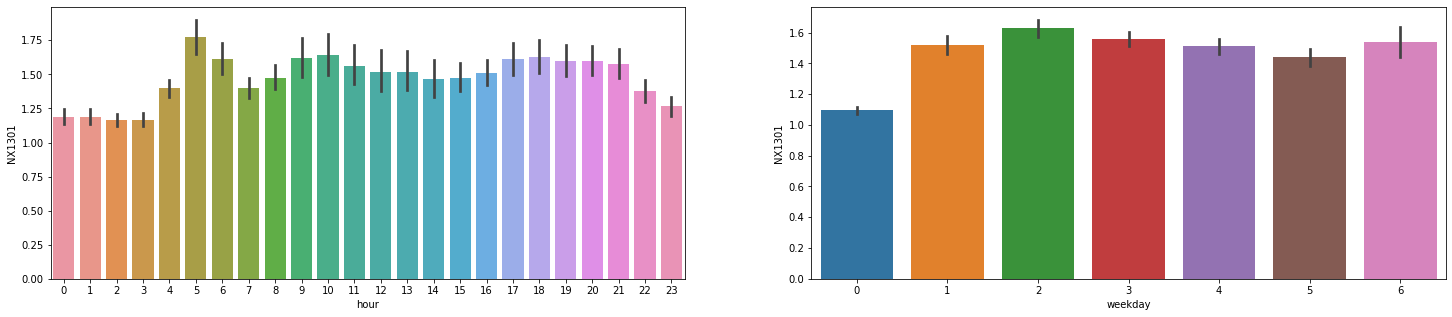

In [10]:
plt.subplots(1, 2, figsize=(25, 5))
plt.subplot(1, 2, 1)

# X26 -> NX1301 이 맞음
temp_df = test[['Time', 'NX1301']].dropna()
temp_df['hour'] = pd.to_datetime(temp_df['Time']).dt.hour
sns.barplot(x='hour', y='NX1301', data=temp_df)


plt.subplot(1, 2, 2)

temp_df = test[['Time', 'NX1301']].dropna()
temp_df['weekday'] = pd.to_datetime(temp_df['Time']).dt.weekday
sns.barplot(x='weekday', y='NX1301', data=temp_df)
plt.show()

## 4. 변수 선택 및 모델 구축
### Feature Engineering & Initial Modeling
- 각각의 모델을 만듬으로서 총 200개의 모델 생성 -> (NX1301, NX1302 ... 각각)
- 베이스모델은 xgboost로 시작
- 속도가 느렸기 때문에, lightgbm으로 변환(성능의 상승) -> xgboost의 경우 overfit의 문제가 있었을 것이라 추정
- kfold, loocv, validation subset 구축 등의 모든 방법이 cv==lb가 맞지 않는 경우 발생
- LB를 기준으로 파라미터 조절을 수행
- **보다 robust한 모델을 구축하기 위해 (= 온도 포함, 미포함으로 앙상블했고, 시드 앙상블도 했으니까 -> 강건하다!)**
- smape metrics 에서 weight가 강한 hour 예측 모델은
- 결론적으로 시드앙상블을 안한 모델이 private score가 좋았습니다.

In [25]:
# case1 'month', 'week', 'weekday', 'day', 'hour', 'is_holiday', 'next_week_mean', 'next_week_std', 'temp'
# case2 'month', 'week', 'weekday', 'day', 'hour', 'is_holiday', 'next_week_mean', 'next_week_std'

# case3  month', 'week', 'weekday', 'day', 'hour', 'is_holiday'

In [16]:
## hour 사용 온도 포함한 경우와 미포함 한 경우로 결과를 앙상블

submit_dict = defaultdict()
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.03,
        'num_leaves': 2**9,
        'max_depth':-1,
        'tree_learner':'serial',
        'min_child_weight':5, 
        'subsample':0.7,
        'reg_alpha':0.2,
        'reg_lambda':0.2,
        'verbose':-1,
        'seed': 0
    }

#### Case
# - include temperature and hour predict (온도 ,시간 포함 예측)
# - exclude temperature and hour predict (온도, 시간 제외 예측)
# - exclude temperature and day, month predict (온도, 일, 월 제외 예측)

## temp 
# 진행상황 그래프바
for idx in tqdm.tqdm_notebook(list(range(200))):
    hours, using_temp = True, True
    
    # def merge(train, col, hour=True, use_temp=True):
    # case (1) 온도쓴 경우
    # sub['meter_id'][idx] == NX1301, NX1302, ~ NX1500 
    train_df, test_df = merge(test, sub['meter_id'][idx],
                              hour=hours, use_temp=using_temp # 시간 사용여부, 온도 사용여부
                             )
    # print(sub['meter_id'][idx])
    #print(train_df.shape, test_df.shape)
    glo_pred1 = np.zeros(len(test_df)) # predict 점수 초기화
    
    # random_seed
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED 
        pred1 = np.zeros(len(test_df)) # pred 점수 초기화
        
        # 사용 feature 들 -> 해당 변수들 제외하고
        # 'month', 'week', 'weekday', 'day', 'hour', 'is_holiday', 'next_week_mean', 'next_week_std', 'temp'
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        # print('feature', feature)
        
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 1, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0) ## 원래는 num_round 100
            
            # predict 점수 평균
            pred1 += model.predict(test_df[feature])/5
        pred1[pred1<0] = train_df['target'].min()
        glo_pred1 += pred1/5
    
    ###################################### 온도 안쓰고 시간변수들만 쓴 경우
    # case (2) 온도 안쓴 경우
    using_temp=False
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours, use_temp=using_temp)
    glo_pred2 = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred2 = np.zeros(len(test_df)) # predict 점수 초기화
        
        # 사용 feature 들
        # 'month', 'week', 'weekday', 'day', 'hour', 'is_holiday', 'next_week_mean', 'next_week_std'
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        # print('feature2', feature)
        
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        
        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 1, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0) ## 원래는 num_round 200
            pred2 += model.predict(test_df[feature])/5
        pred2[pred2<0] = train_df['target'].min()
        glo_pred2 += pred2/5
    
    # 최종 submit dict 생성
    submit_dict[idx] = glo_pred1*0.6 + glo_pred2*0.4

c:\users\urse\anaconda3\envs\untitled\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


(1625, 16) (24, 15)
(4566, 16) (24, 15)
(4633, 16) (24, 15)
(4554, 16) (24, 15)
(4558, 16) (24, 15)
(4593, 16) (24, 15)
(4541, 16) (24, 15)
(4584, 16) (24, 15)
(4525, 16) (24, 15)
(4544, 16) (24, 15)
(4549, 16) (24, 15)
(4985, 16) (24, 15)
(4622, 16) (24, 15)
(4546, 16) (24, 15)
(4556, 16) (24, 15)
(4551, 16) (24, 15)
(4641, 16) (24, 15)
(4536, 16) (24, 15)
(4567, 16) (24, 15)
(1625, 16) (24, 15)
(4579, 16) (24, 15)
(4560, 16) (24, 15)
(4539, 16) (24, 15)
(4985, 16) (24, 15)
(4609, 16) (24, 15)
(4985, 16) (24, 15)
(4557, 16) (24, 15)
(4499, 16) (24, 15)
(4541, 16) (24, 15)
(4617, 16) (24, 15)
(4508, 16) (24, 15)
(4985, 16) (24, 15)
(4535, 16) (24, 15)
(4580, 16) (24, 15)
(4615, 16) (24, 15)
(4985, 16) (24, 15)
(4558, 16) (24, 15)
(4611, 16) (24, 15)
(4632, 16) (24, 15)
(4536, 16) (24, 15)
(4538, 16) (24, 15)
(4537, 16) (24, 15)
(4985, 16) (24, 15)
(4653, 16) (24, 15)
(4553, 16) (24, 15)
(4536, 16) (24, 15)
(4509, 16) (24, 15)
(4356, 16) (24, 15)
(4553, 16) (24, 15)
(4873, 16) (24, 15)


meter_id,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,NX1310,...,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500
0,1.44493,0.480162,0.32354,0.336010,0.354795,0.184744,0.434617,0.334645,0.092531,0.256003,...,0.233310,0.217117,0.354331,0.334360,0.202610,0.299665,0.228870,1.443005,0.557582,0.380620
1,1.44493,0.480162,0.32227,0.334556,0.353460,0.182361,0.434434,0.333385,0.091618,0.256003,...,0.230971,0.217117,0.349836,0.331457,0.202610,0.299549,0.228659,1.443005,0.557582,0.380349
2,1.44493,0.478058,0.32227,0.334507,0.353420,0.182182,0.434109,0.333373,0.091618,0.256033,...,0.229546,0.215976,0.348176,0.328004,0.202877,0.299528,0.227494,1.443005,0.557582,0.380349
3,1.44493,0.475410,0.32227,0.334507,0.353420,0.182182,0.433959,0.333373,0.091618,0.256033,...,0.228916,0.215682,0.347135,0.327750,0.202877,0.299513,0.226629,1.443005,0.557582,0.380071
4,1.44183,0.475263,0.32227,0.334507,0.353420,0.182182,0.433959,0.333373,0.091618,0.256033,...,0.228839,0.213986,0.346838,0.327750,0.202610,0.299513,0.226629,1.443005,0.557582,0.379918


In [19]:
# 최종 파일 생성 - 시간별
submit_df = pd.DataFrame(submit_dict) # dict -> df로
submit_df.columns = sub['meter_id']
submit_df

meter_id,NX1301,NX1302,NX1303,NX1304,NX1305,NX1306,NX1307,NX1308,NX1309,NX1310,...,NX1491,NX1492,NX1493,NX1494,NX1495,NX1496,NX1497,NX1498,NX1499,NX1500
0,1.444930,0.480162,0.323540,0.336010,0.354795,0.184744,0.434617,0.334645,0.092531,0.256003,...,0.233310,0.217117,0.354331,0.334360,0.202610,0.299665,0.228870,1.443005,0.557582,0.380620
1,1.444930,0.480162,0.322270,0.334556,0.353460,0.182361,0.434434,0.333385,0.091618,0.256003,...,0.230971,0.217117,0.349836,0.331457,0.202610,0.299549,0.228659,1.443005,0.557582,0.380349
2,1.444930,0.478058,0.322270,0.334507,0.353420,0.182182,0.434109,0.333373,0.091618,0.256033,...,0.229546,0.215976,0.348176,0.328004,0.202877,0.299528,0.227494,1.443005,0.557582,0.380349
3,1.444930,0.475410,0.322270,0.334507,0.353420,0.182182,0.433959,0.333373,0.091618,0.256033,...,0.228916,0.215682,0.347135,0.327750,0.202877,0.299513,0.226629,1.443005,0.557582,0.380071
4,1.441830,0.475263,0.322270,0.334507,0.353420,0.182182,0.433959,0.333373,0.091618,0.256033,...,0.228839,0.213986,0.346838,0.327750,0.202610,0.299513,0.226629,1.443005,0.557582,0.379918
5,1.441414,0.475188,0.324858,0.334637,0.353420,0.182182,0.433959,0.333373,0.091618,0.256931,...,0.228839,0.213935,0.346838,0.327750,0.202610,0.299513,0.226629,1.443005,0.557582,0.379715
6,1.441414,0.475188,0.325850,0.334313,0.353492,0.182189,0.434020,0.333373,0.091731,0.258061,...,0.228882,0.213948,0.347700,0.331319,0.202578,0.298726,0.226629,1.443005,0.557582,0.379438
7,1.441414,0.475289,0.325935,0.334313,0.355274,0.182189,0.434048,0.333417,0.094421,0.258061,...,0.228882,0.213954,0.347700,0.331854,0.202578,0.299376,0.226766,1.443005,0.557582,0.379314
8,1.441414,0.475639,0.325396,0.334425,0.355281,0.182189,0.437143,0.334444,0.093140,0.256162,...,0.230561,0.213954,0.347700,0.332188,0.202578,0.299230,0.227375,1.531936,0.557554,0.379333
9,1.441414,0.479794,0.324349,0.334663,0.358692,0.182524,0.437429,0.334051,0.093097,0.255875,...,0.230730,0.213949,0.353628,0.332121,0.202578,0.299496,0.227554,1.555117,0.557251,0.379276


In [20]:
# 전치행렬로 뒤집고
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns[:25]
submit_df_hour = submit_df.copy()
submit_df_hour

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h
0,NX1301,1.444930,1.444930,1.444930,1.444930,1.441830,1.441414,1.441414,1.441414,1.441414,...,1.440821,1.440821,1.440821,1.440821,1.440821,1.440886,1.440886,1.440886,1.444596,1.444199
1,NX1302,0.480162,0.480162,0.478058,0.475410,0.475263,0.475188,0.475188,0.475289,0.475639,...,0.489778,0.490156,0.490156,0.490407,0.491841,0.490366,0.490366,0.490145,0.489006,0.488598
2,NX1303,0.323540,0.322270,0.322270,0.322270,0.322270,0.324858,0.325850,0.325935,0.325396,...,0.324350,0.324350,0.324406,0.325053,0.325393,0.325517,0.325540,0.325437,0.323873,0.323873
3,NX1304,0.336010,0.334556,0.334507,0.334507,0.334507,0.334637,0.334313,0.334313,0.334425,...,0.333846,0.333792,0.333770,0.334179,0.334331,0.335417,0.337072,0.338668,0.337999,0.336413
4,NX1305,0.354795,0.353460,0.353420,0.353420,0.353420,0.353420,0.353492,0.355274,0.355281,...,0.362083,0.361489,0.361303,0.361794,0.361988,0.361992,0.361868,0.361994,0.361994,0.359281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NX1496,0.299665,0.299549,0.299528,0.299513,0.299513,0.299513,0.298726,0.299376,0.299230,...,0.300395,0.300145,0.300008,0.299920,0.299914,0.300461,0.300586,0.302018,0.301672,0.299746
196,NX1497,0.228870,0.228659,0.227494,0.226629,0.226629,0.226629,0.226629,0.226766,0.227375,...,0.229167,0.229108,0.229198,0.229914,0.231629,0.231165,0.232483,0.232361,0.232361,0.229915
197,NX1498,1.443005,1.443005,1.443005,1.443005,1.443005,1.443005,1.443005,1.443005,1.531936,...,1.546840,1.536648,1.536648,1.536648,1.514901,1.493496,1.500582,1.500996,1.500996,1.454511
198,NX1499,0.557582,0.557582,0.557582,0.557582,0.557582,0.557582,0.557582,0.557582,0.557554,...,0.557251,0.557251,0.557251,0.557525,0.557513,0.557628,0.557628,0.557628,0.557628,0.557628


In [22]:
# 파라미터 값들 위와 동일
submit_dict = defaultdict()
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.03,
        'num_leaves': 2**9,
        'max_depth':-1,
        'tree_learner':'serial',
        'min_child_weight':5, 
        'subsample':0.7,
        'reg_alpha':0.2,
        'reg_lambda':0.2,
        'verbose':-1,
        'seed': 0
    }

# 7월 1일 ~ 7월 10일 일별 사용량 / 7월 ~ 11월 월별 사용예측량
###################################### 온도 안쓰고 시간변수들만 쓴 경우
# case (3) 시간변수들 안쓰고
for idx in tqdm.tqdm_notebook(list(range(200))):
    hours=False
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours)
    glo_pred = np.zeros(len(test_df)) # 예측값 초기화
    
    # random seed
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred = np.zeros(len(test_df)) # 예측값들 초기화
    
        # feature3 ['month', 'week', 'weekday', 'day', 'hour', 'is_holiday']
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow']]
        #print('feature3', feature)
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 1, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0) ## 원래는 num_round 200
            pred += model.predict(test_df[feature])/5
        pred[pred<0] = train_df['target'].min()
        glo_pred += pred/5
    submit_dict[idx] = glo_pred
    
submit_df = pd.concat([pd.DataFrame(submit_dict).loc[:23], 
                       pd.concat([pd.DataFrame([j for i in range(10) for j in str(i) * 24], columns=['house']),
                                  pd.DataFrame(submit_dict).loc[:239]], 1).groupby('house').sum().reset_index(drop=True),
                       pd.concat([test_df['Time'].dt.to_period('m'), pd.DataFrame(submit_dict)], 1).groupby('Time').sum().reset_index(drop=True)])

c:\users\urse\anaconda3\envs\untitled\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [24]:
submit_df.columns = sub['meter_id']
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns
submit_df_day = submit_df.copy()
submit_df_day

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,NX1301,1.461234,1.461234,1.461234,1.461234,1.455113,1.455113,1.455113,1.455113,1.455113,...,35.226283,35.024434,34.999471,34.950531,35.189719,1088.897374,1089.049270,1053.784539,1088.974192,1053.843822
1,NX1302,0.483091,0.483065,0.482825,0.478206,0.478206,0.478206,0.478206,0.478206,0.478721,...,11.564931,11.578109,11.679363,11.567136,11.554418,359.442804,359.366934,348.494007,359.791182,348.311020
2,NX1303,0.325067,0.323990,0.323990,0.323990,0.323990,0.326458,0.327646,0.327821,0.327056,...,7.823523,7.821488,7.827255,7.820413,7.818689,242.507666,242.502266,236.848061,244.752294,236.873342
3,NX1304,0.336443,0.334968,0.334291,0.334239,0.334279,0.334498,0.334443,0.334443,0.334667,...,8.050492,8.050545,8.050408,8.048587,8.043998,249.454820,249.456471,241.937938,249.999200,242.066178
4,NX1305,0.355353,0.354967,0.354967,0.354967,0.354967,0.354967,0.354968,0.356703,0.356794,...,8.606614,8.599613,8.611848,8.609182,8.628747,267.070651,267.196145,258.702045,267.456881,258.993973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NX1496,0.297601,0.297634,0.297634,0.297604,0.297596,0.297596,0.297574,0.298357,0.298040,...,7.144890,7.159685,7.158832,7.139958,7.139028,221.670479,221.677238,212.840687,219.780611,213.188702
196,NX1497,0.229599,0.229575,0.228852,0.227661,0.227661,0.227661,0.227661,0.227785,0.228333,...,5.521415,5.531164,5.529221,5.517733,5.517633,171.240210,171.247236,165.722288,171.229500,165.687850
197,NX1498,1.434248,1.434248,1.434248,1.434342,1.435401,1.435401,1.435401,1.435401,1.628160,...,34.696691,35.579117,36.680282,34.681615,34.788463,1090.031312,1088.141936,1061.301028,1093.860518,1059.034263
198,NX1499,0.564058,0.564058,0.564058,0.564058,0.564058,0.564058,0.564058,0.564058,0.563879,...,13.927490,13.534996,13.534996,13.927352,13.927490,428.206092,428.246089,413.016474,427.891330,414.702532


In [26]:
submit_df = pd.concat([submit_df_hour, submit_df_day.iloc[:, 25:]], 1)
submit_df.head()

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,...,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,NX1301,1.444930,1.444930,1.444930,1.444930,1.441830,1.441414,1.441414,1.441414,1.441414,...,35.226283,35.024434,34.999471,34.950531,35.189719,1088.897374,1089.049270,1053.784539,1088.974192,1053.843822
1,NX1302,0.480162,0.480162,0.478058,0.475410,0.475263,0.475188,0.475188,0.475289,0.475639,...,11.564931,11.578109,11.679363,11.567136,11.554418,359.442804,359.366934,348.494007,359.791182,348.311020
2,NX1303,0.323540,0.322270,0.322270,0.322270,0.322270,0.324858,0.325850,0.325935,0.325396,...,7.823523,7.821488,7.827255,7.820413,7.818689,242.507666,242.502266,236.848061,244.752294,236.873342
3,NX1304,0.336010,0.334556,0.334507,0.334507,0.334507,0.334637,0.334313,0.334313,0.334425,...,8.050492,8.050545,8.050408,8.048587,8.043998,249.454820,249.456471,241.937938,249.999200,242.066178
4,NX1305,0.354795,0.353460,0.353420,0.353420,0.353420,0.353420,0.353492,0.355274,0.355281,...,8.606614,8.599613,8.611848,8.609182,8.628747,267.070651,267.196145,258.702045,267.456881,258.993973


### 5. 모델 학습 및 검증
### Model Tuning & Evaluation

In [27]:
submit_df.to_csv('test_submission.csv', index=False)

### 6. 결과 및 결언
### Conclusion & Discussion
- hour가 가장 높은 영향력을 지님
- hour를 기반으로 여러가지 변수를 만들고 싶었으나, 모두 overfit의 요소가 되었습니다.

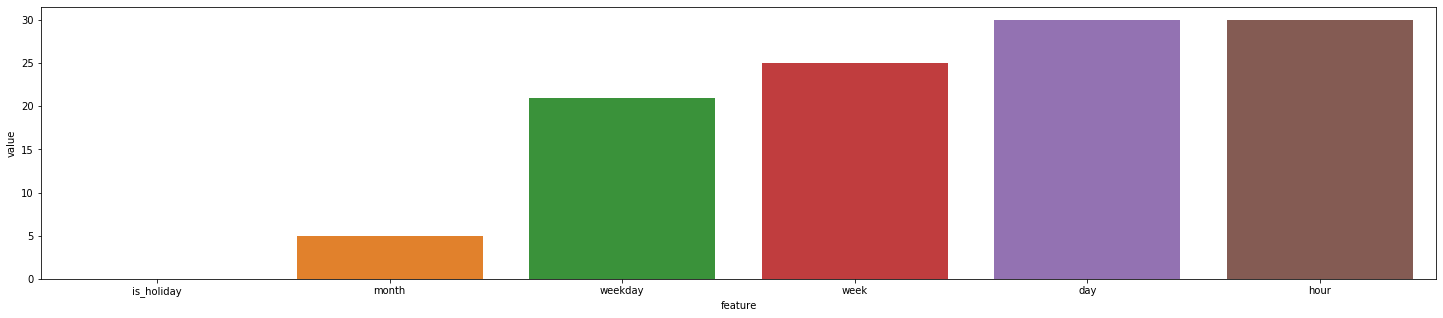

In [28]:
plt.figure(figsize=(25, 5))
sns.barplot(x='feature', y='value', data=pd.DataFrame(sorted(zip(model.feature_importance(), feature)), columns=['value', 'feature']))
plt.show()

- 각각의 경우에 세밀하게 outlier를 선정하는 것을 생각해 보았습니다.
- raw data를 학습하는 것으로써 std, mean, quantile 등의 다양한 통계량을 통해서 비슷한 meter_id를 탐지하고 비슷한 meter_id별로 예측하는 것을 생각해 보았습니다.